In [1]:
import numpy as np
import pandas as pd
import graphviz
import pydotplus
import matplotlib.pyplot as plt

from sklearn import tree, ensemble, model_selection
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

classification_data_path = './data/diabetes.csv'

classification_feature_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi',  'pedigree', 'age',  'label']

regression_data_info = fetch_california_housing()
regression_feature_names = regression_data_info.feature_names

test_data_ratio = 0.3

random_state = 0

n_estimators = 3
max_depth = 3

visualize_feature = 5

In [2]:
class RegressionDataLoader:
  def __init__(self, data_info, feature_names, test_data_ratio, random_state):
    self.data_info = data_info
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    self.data_infos = self.get_data_infos()
    self.data, self.label = self.get_dataset()

    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()


  def __call__(self, flag):
    if flag == 'train':
        return self.train_data, self.train_label
    else:
        return self.test_data, self.test_label

  def get_data_infos(self):
    df = pd.DataFrame(self.data_info.data, columns=self.feature_names)
    df['label'] = self.data_info.target

    return df

  def get_dataset(self):
    data, label = self.data_infos.drop(columns=['label']), self.data_infos['label']

    return data, label

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.data, self.label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data, train_label, test_data, test_label


regression_dataloader = RegressionDataLoader(regression_data_info, regression_feature_names, test_data_ratio, random_state)
regression_train_data, regression_train_label = regression_dataloader('train')
regression_test_data, regression_test_label = regression_dataloader('test')

print(f'regression train data: {regression_train_data.shape}/regression train label: {regression_train_label.shape}')
print(f'regression test data: {regression_test_data.shape}/regressiontest label: {regression_test_label.shape}')

regression train data: (14448, 8)/regression train label: (14448,)
regression test data: (6192, 8)/regressiontest label: (6192,)


In [3]:
class SklearnRandomForestRegressor:
  def __init__(self, feature_names, n_estimators, max_depth, visualize_feature, random_state):
    self.feature_names = feature_names
    self.n_estimators = n_estimators
    self.max_depth = max_depth
    self.visualize_feature = visualize_feature
    self.random_state = random_state

    self.regressor = ensemble.RandomForestRegressor(
        n_estimators=self.n_estimators,
        max_depth=self.max_depth,
        random_state=self.random_state
    )

  def __call__(self, data):
    return self.regressor.predict(data)

  def train_model(self, train_data, train_label):
      self.regressor.fit(train_data, train_label)

  def test_model(self, test_data, test_label):
    pred = self.regressor.predict(test_data)
    mse = mean_squared_error(test_label, pred)
    mae = mean_absolute_error(test_label, pred)

    print(f'mse: {mse}/mae: {mae}')

  def show_trees(self):
    for index, decision_tree in enumerate(self.regressor.estimators_):
      tree.plot_tree(decision_tree)

  def plot_feature_importance(self):
    feature_importance = self.regressor.feature_importances_

    index = np.argsort(feature_importance)[::-1]
    feature_name = [self.feature_names[i] for i in index]

    most_important_feature_index = index[:self.visualize_feature]
    most_important_feature = feature_importance[most_important_feature_index]
    most_important_feature_name = [feature_name[i] for i in most_important_feature_index]

    plt.title(f'Most Important {self.visualize_feature} Features')
    plt.bar(range(self.visualize_feature), most_important_feature, align='center')
    plt.xticks(range(self.visualize_feature), most_important_feature_name, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

sklearn_rf_regressor= SklearnRandomForestRegressor(regression_feature_names, n_estimators, max_depth, visualize_feature, random_state)
sklearn_rf_regressor.train_model(regression_train_data, regression_train_label)
sklearn_rf_regressor.test_model(regression_test_data, regression_test_label)

mse: 0.613446374491919/mae: 0.5840954701580117


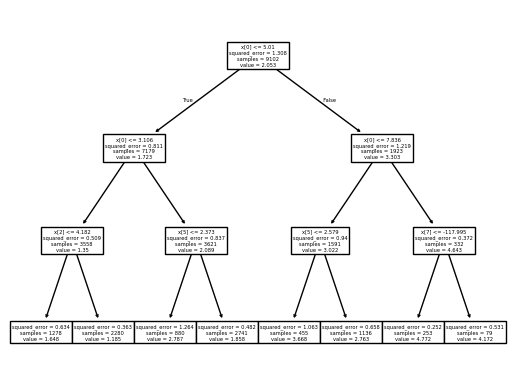

In [4]:
sklearn_rf_regressor.show_trees()

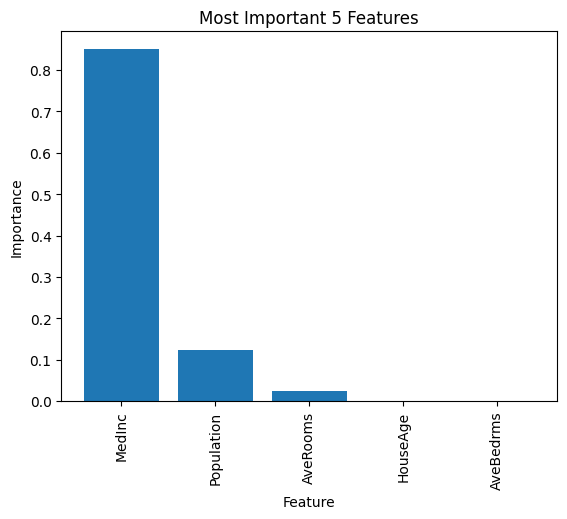

In [5]:
sklearn_rf_regressor.plot_feature_importance()

In [6]:
class BinomialClassificationDataLoader:
  def __init__(self, path, feature_names, test_data_ratio, visualize_feature, random_state):
    self.data_path = path
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.visualize_feature = visualize_feature
    self.random_state = random_state

    self.csv_infos = self.get_csv_infos()
    self.csv_data, self.csv_label = self.get_csv_dataset()
    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()

  def __call__(self, flag):
    if flag == 'train':
      return self.train_data, self.train_label
    elif flag == 'test':
      return self.test_data, self.test_label

  def get_csv_infos(self):
    df = pd.read_csv(self.data_path, header=None).drop([0], axis=0)
    df.columns = self.feature_names

    return df

  def get_csv_dataset(self):
    data, label = self.csv_infos[self.feature_names[:-1]], self.csv_infos[self.feature_names[-1]].astype(int)

    return data, label

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.csv_data, self.csv_label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data, train_label, test_data, test_label


classification_dataloader = BinomialClassificationDataLoader(classification_data_path, classification_feature_names, test_data_ratio, visualize_feature, random_state)
classification_train_data, classification_train_label = classification_dataloader('train')
classification_test_data, classification_test_label = classification_dataloader('test')

print(f'classification train data: {classification_train_data.shape}/classification train label: {classification_train_label.shape}')
print(f'classification test data: {classification_test_data.shape}/classification test label: {classification_test_label.shape}')

classification train data: (537, 8)/classification train label: (537,)
classification test data: (231, 8)/classification test label: (231,)


In [8]:
class SklearnRandomForestClassifier:
  def __init__(self, feature_names, n_estimators, max_depth, visualize_feature, random_state):
    self.feature_names = feature_names
    self.n_estimators = n_estimators
    self.max_depth = max_depth
    self.visualize_feature = visualize_feature
    self.random_state = random_state

    self.classifier = ensemble.RandomForestClassifier(
        n_estimators=self.n_estimators,
        max_depth=self.max_depth,
        random_state=self.random_state
    )

  def __call__(self, data):
    return self.classifier.predict(data)

  def train_model(self, train_data, train_label):
      self.classifier.fit(train_data, train_label)

  def test_model(self, test_data, test_label):

    pred = self.classifier.predict(test_data)
    accuracy = accuracy_score(test_label, pred)
    precision = precision_score(test_label, pred)
    recall = recall_score(test_label, pred)
    f1_measure = f1_score(test_label, pred)

    print(f'acc: {accuracy}/precision: {precision}/recall: {recall}/f1-measure: {f1_measure}')

  def show_trees(self):
    for index, decision_tree in enumerate(self.classifier.estimators_):
      tree.plot_tree(decision_tree)

  def plot_feature_importance(self):
    feature_importance = self.classifier.feature_importances_

    index = np.argsort(feature_importance)[::-1]
    feature_name = [self.feature_names[i] for i in index]

    most_important_feature_index = index[:self.visualize_feature]
    most_important_feature = feature_importance[most_important_feature_index]
    most_important_feature_name = [feature_name[i] for i in most_important_feature_index]

    plt.title(f'Most Important {self.visualize_feature} Features')
    plt.bar(range(self.visualize_feature), most_important_feature, align='center')
    plt.xticks(range(self.visualize_feature), most_important_feature_name, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

sklearn_rf_classifier = SklearnRandomForestClassifier(classification_feature_names, n_estimators, max_depth, visualize_feature, random_state)
sklearn_rf_classifier.train_model(classification_train_data, classification_train_label)
sklearn_rf_classifier.test_model(classification_test_data, classification_test_label)


acc: 0.7662337662337663/precision: 0.6923076923076923/recall: 0.4864864864864865/f1-measure: 0.5714285714285714


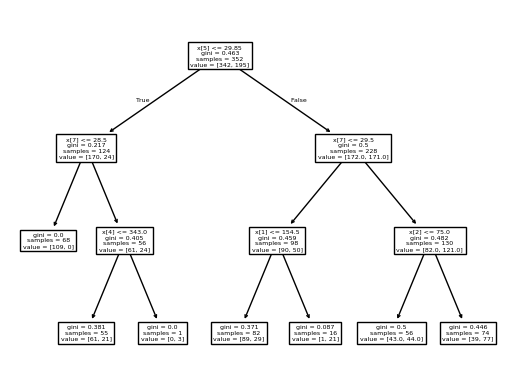

In [9]:
sklearn_rf_classifier.show_trees()

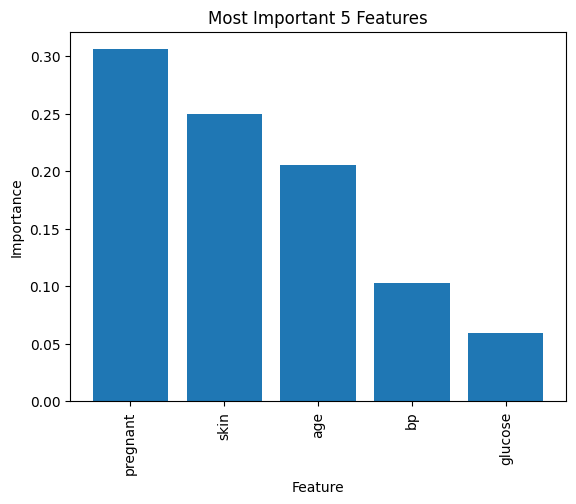

In [10]:
sklearn_rf_classifier.plot_feature_importance()